In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seattle/calendar.csv
/kaggle/input/seattle/listings.csv
/kaggle/input/seattle/reviews.csv


**Section 1: Bussines Understanding**

With the following project we seek to answer three interesting questions that arose about the rental data provided by AIRBNB Seattle and that will be useful in making decisions 
* Question 1: What are the 8 most popular neighborhoods to advertise in Seattle? 
* Question 2: What are the average prices for different types of properties?
* Question 3: How does the time of the year impact the rental prices?

**Libraries**

Amount of required libraries

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose


**Section 2: Data Understanding**

The three dataframe provided will be loaded to show the information collected since 2008.

In [4]:
calendar = pd.read_csv('/kaggle/input/seattle/calendar.csv')
rws = pd.read_csv('/kaggle/input/seattle/reviews.csv')
lis = pd.read_csv('/kaggle/input/seattle/listings.csv')


**Section 3: Data preparation**

At this point we will select the variables necessary for the analysis of the questions posed.

In [5]:
lis[['id', 'neighbourhood', 'property_type', 'price', 'review_scores_value']].head()


,id,neighbourhood,property_type,price,review_scores_value
0,241032,Queen Anne,Apartment,$85.00,10.0
1,953595,Queen Anne,Apartment,$150.00,10.0
2,3308979,Queen Anne,House,$975.00,10.0
3,7421966,Queen Anne,Apartment,$100.00,NaN
4,278830,Queen Anne,House,$450.00,9.0


**Section 4: Evaluate the Results**

**Question 1: What are the 8 most popular neighborhoods to advertise in Seattle?**

We will delete records that do not contain information on the neighborhood in which the reservation was made as they affect the measurement of the most popular neighborhood.to answer this question it is necessary to purify the data, for them we must eliminate the records of the properties that do not have a neighborhood assigned, since we seek to classify this characteristic.

In [7]:
lis = lis.dropna(subset=['neighbourhood'])

By performing a count ordered from highest to lowest we can extract the table with the 8 most popular neighborhoods.we will find the 8 most popular neighborhoods in the Airbnb data by number of customers booking, counting and organizing them in descending order, finally we will show the result in a bar chart.

In [6]:
top_neighborhoods = lis['neighbourhood'].value_counts().nlargest(8)
top_neighborhoods


Capitol Hill           351
Ballard                213
Belltown               204
Minor                  192
Queen Anne             187
Fremont                148
Wallingford            143
University District    107
Name: neighbourhood, dtype: int64

In [7]:
#We create a list with the 8 neighborhoods obtained from the previous step 
top8 = list(top_neighborhoods.index)
top8

['Capitol Hill',
 'Ballard',
 'Belltown',
 'Minor',
 'Queen Anne',
 'Fremont',
 'Wallingford',
 'University District']

We will use the 8 neighborhoods we obtained to make a grouping by housing type and thus have a count of them.

In [11]:
#We generate a count grouped by type of housing and neighborhood. 

PP_types = lis.groupby(['neighbourhood','property_type'], as_index = False)['id'].count()
PP_types = (PP_types.
                        sort_values(by = 'id', ascending = False)
                       ) 

PP_types.head()

,neighbourhood,property_type,id
41,Capitol Hill,Apartment,254
22,Belltown,Apartment,181
19,Ballard,House,136
171,Minor,House,110
280,Wallingford,House,98


In [12]:
#We will filter the grouping of housing types by the neighborhoods we have stored in the top 8.

PP_types = PP_types[PP_types['neighbourhood'].isin(top8)]

print(PP_types['neighbourhood'].unique())
PP_types.head()

['Capitol Hill' 'Belltown' 'Ballard' 'Minor' 'Wallingford' 'Queen Anne'
 'Fremont' 'University District']


,neighbourhood,property_type,id
41,Capitol Hill,Apartment,254
22,Belltown,Apartment,181
19,Ballard,House,136
171,Minor,House,110
280,Wallingford,House,98


**Visualise**

We will create a bar chart to visualize the most popular neighborhoods in Seattle.

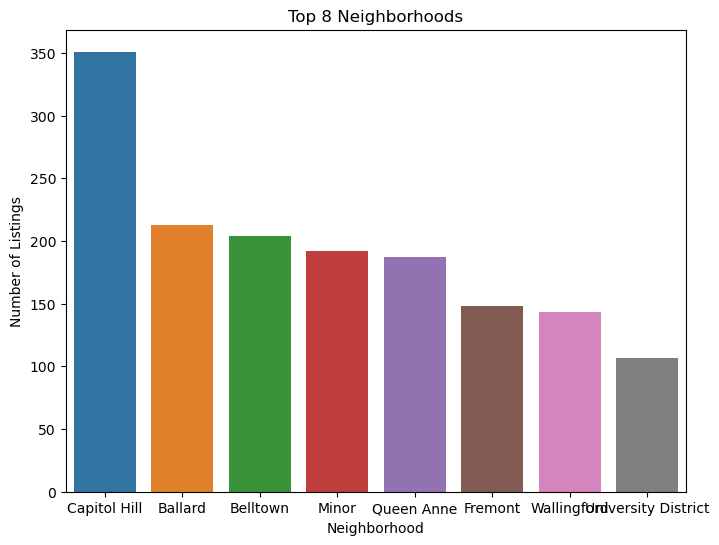

In [19]:
plt.figure(figsize=(8,6))
sns.barplot(x=top_neighborhoods.index, y=top_neighborhoods.values)
plt.title('Top 8 Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')
plt.show()


**Results**

We found that Capiton Hill is the most popular neighborhood with a total of 351 listings, 72% of which correspond to apartments, followed by Ballard with a total of 213 listings, however, the most popular type of housing is the house with 64% of the total number of listings.


**Question 2: What are the average prices for different types of properties?**

we will find the average lease price by type of property. first, we will convert the price variable to float type in order to find the average of the prices. 

In [25]:
#convert variable float type
lis['price'] = lis['price'].replace('[\$,]', '', regex=True).astype(float)
#We find the average price of all the data
avg=lis['price'].mean()
avg

127.97616553169199

In [28]:
# we find the average price by type of property 
avg_price=lis.groupby(['property_type'])['price'].mean().sort_values(ascending=False)
avg_price


property_type
Boat               282.375000
Condominium        151.109890
Loft               135.700000
House              132.351414
Townhouse          129.457627
Apartment          122.932670
Camper/RV          120.461538
Bungalow           115.615385
Bed & Breakfast    112.054054
Cabin              104.666667
Treehouse          101.000000
Yurt               100.000000
Chalet              98.500000
Other               94.681818
Tent                54.000000
Dorm                39.500000
Name: price, dtype: float64

**Visualise**

We will create a bar chart to see the order of average prices by property type.

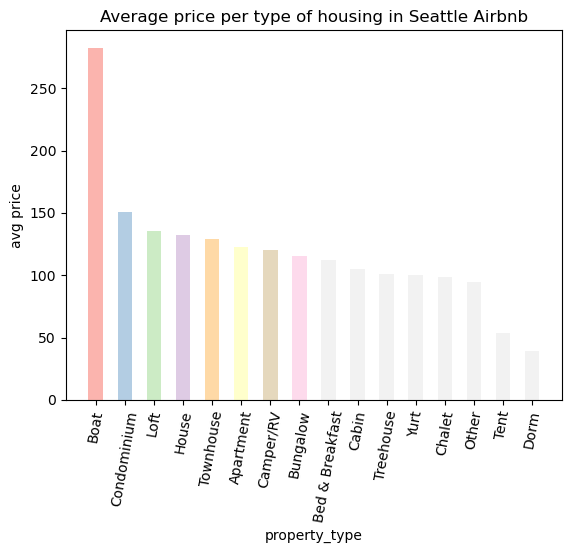

In [34]:

# select a color scale for the chart
color_palette = plt.get_cmap('Pastel1')
num_colors = len(avg_price)

fig, ax = plt.subplots()
ax.bar(avg_price.index, avg_price.values, width=0.5,color=color_palette(range(num_colors)))
# Rotate the x-axis legend to improve the visualization.
plt.xticks(rotation=80)
# Configure labels and title
ax.set_xlabel('property_type')
ax.set_ylabel('avg price')
ax.set_title('Average price per type of housing in Seattle Airbnb')

# Mostrar el gráfico
plt.show()


**Results**

we found that the highest average rental price is for boats with an average value of 221.6.
We also found that only 4 of the property types exceed the average rental price. 

**Question 3: How does the time of the year impact the rental prices?**

With this question we want to analyze if the season of the year has any impact on the price of rentals, and thus know when they can be more profitable for users and hosts. 

We convert the price variable to a float variable so that we can perform operations with it and we will format the date variable to be able to divide it by the stations 

In [38]:
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Convert date column to date objects
calendar['date'] = pd.to_datetime(calendar['date'], format='%Y-%m-%d')


we create the column with the season of the year according to the date and calculate the average price for each one of them

In [42]:
#Create a new column in the Data for the season of the year
calendar['season'] = pd.cut(calendar['date'].dt.month, [ 2, 5, 8, 11, 12], labels=['Invierno', 'Primavera', 'Verano', 'Otoño'])

# Group the data by season of the year and calculate the average price of the accommodations.
avg_price_season = calendar.groupby('season')['price'].mean()

**Visualization**

We create a graph that allows us to see the average prices in each season of the year and identify the highest ones. 

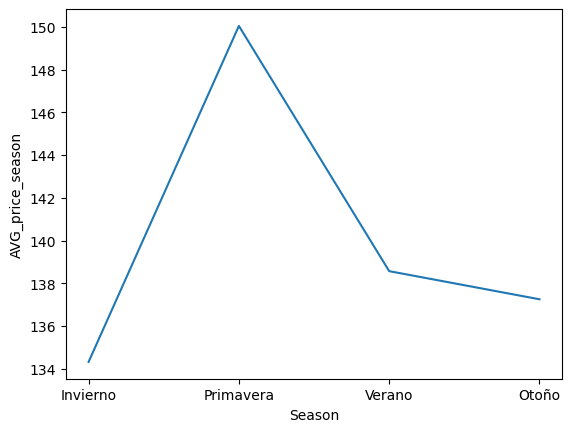

In [44]:
# Visualize the results
plt.plot(avg_price_season)
plt.xlabel('Season')
plt.ylabel('AVG_price_season')
plt.show()

**results**

we found that the season with the highest average booking price for Seattle accommodations is spring and the season with the lowest average booking price is winter. 